Remember to restart the kernal in your previous Jupyter Lab document to break the connection with any other devices before beginning this one.

In [1]:
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML
from pathlib import Path
from time import monotonic, sleep

import numpy as np
import matplotlib.pyplot as plt
import math

import qcodes as qc
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.logger import start_all_logging
start_all_logging()

from scipy.optimize import curve_fit
import numpy as np

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research as stanford_research

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nv-group01\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nv-group01\.qcodes\logs\240605-31920-qcodes.log


In [2]:
# pulse_blaster = spincore.PulseBlasterESRPRO(name='pulse_blaster', board_number=0)
# pulse_blaster.core_clock(500)                     #Sets the clock speed, 
#                                                   #must be called immediately after connecting to the PulseBlaster
lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='ASRL5::INSTR', terminator='\r')
# microwave_src=anritsu.MG3681A(name='microwave_src', address='ASRL4::INSTR', terminator='\r\n')
# microwave_src.output('OFF')
# pulse_blaster.stop()

Connected to: Stanford_Research_Systems SR830 (serial:s/n32132, firmware:ver1.07) in 0.34s


In [3]:
from PulseBlasterUSB import *
pulse_blaster = PulseBlasterUSB()

## Longitudinal $T_1$ Relaxation Time

The laser pulse sequence for this task will need to be altered. The new pulse sequence will consist of pulses in the following order:
1. Initialisation pulse of 500μs length. 
2. A first Readout pulse of 500μs length after a time delay τ.
3. A second Readout pulse of same length that is 180◦ away from the first readout pulse.

The delay τ can then be swept from 100μs to 10 ms to obtain a T1 signature exponential decay signal. Ideally we would only require one initialisation and one readout pulse. However, since our laser is also effectively modulated at the same frequency as the envelope, it would drown out the weak T1 signal. Think about what signal component the lock-in apmplifier measures from the spin signal and from the photoluminescence signal. This experiment requires a very low reference frequency ('ref_f' = 21 Hz). This is because the pulses separated by the delay τ must be able to fit within the envelope period, and the idle time after the pulses needs to be much longer than T1.

In [4]:
#Use this to make a parameter out of anything!
tau = qc.ManualParameter('tau', unit='s')
voltage = qc.ManualParameter('voltage', unit='V')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "T1 Experiment.db")
exp = load_or_create_experiment( #experiment not exp
    experiment_name='T1 Experiment',
    sample_name=""
)

meas = Measurement(exp=exp, name='T1 Experiment')
meas.register_parameter(tau)  # register the first independent parameter
meas.register_parameter(voltage)  # now register the dependent oone

In [5]:
#Stop the pulse blaster so that we can let the states equilibriate and then sweep after initializing.
pulse_blaster.Stop()
tau_0 =  100e-6    #starting tau in seconds
tau_f =  10e-3   #Ending tau in seconds
steps = 30
tau_arr = np.linspace(tau_0, tau_f, steps)

ref_f = 21
ref_D = 0.5
T_ref_on = ref_D/ref_f
T_ref_off = (1 - ref_D)/ref_f

T_laser_on = 500e-6 #Chosen for signal resolution, as we are only doing 1 experiment under the reference for a long reference time.
T_laser_off = 1/(2*ref_f) - T_laser_on #500e-6
def T_idle(tau):
    return 1/(2*ref_f) - (2*T_laser_on + tau)
#TODO: Write the required wait time as a function of tau.
lock_in_amp.time_constant(3)#time constant here)
lock_in_amp.sensitivity(10e-10)#sensativity here)

def T1_PP_new(tau):
    channels = [0, 1]
    durations = [[T_ref_on, T_ref_off], [T_laser_on, tau, T_laser_on, T_idle(tau), T_laser_on, T_laser_off]]
    levels = [[1, 0], [1, 0, 1, 0, 1,  0]]
    instruction  = pulse_blaster.get_Instructions(channels, durations, levels)
    return instruction

In [6]:
#Microwave needs to be off, so this is just to be sure it is.
pulse_blaster.Stop()
with meas.run() as datasaver:
    for i in range(tau_arr.size):
        #Reinitialize the pulse sequence with the new tau.
        #This is a good approach to initializing a new pulse sequence in a loop.
        tau_cur = tau_arr[i]
        print(f'This is run: {i}')
        pulse_blaster.Run_Sequence(T1_PP_new(np.round(tau_arr[i], 7)))
        #For getting your first data point with a new sequence, it helps to give the LIA more time to settle to drastic changes in input data.
        if i == 0:
            sleep(50 *lock_in_amp.time_constant())
        else:
            sleep(30*lock_in_amp.time_constant())
        ###############################
        #Specify the data being saved below
        datasaver.add_result((tau, tau_cur),
                             (voltage, lock_in_amp.R()))
        ###############################
        pulse_blaster.Stop()
    T1 = datasaver.dataset  # convenient to have for data access and plotting

Starting experimental run with id: 19. 
This is run: 0
This is run: 1
This is run: 2
This is run: 3
This is run: 4
This is run: 5
This is run: 6
This is run: 7
This is run: 8
This is run: 9
This is run: 10
This is run: 11
This is run: 12
This is run: 13
This is run: 14
This is run: 15
This is run: 16
This is run: 17
This is run: 18
This is run: 19
This is run: 20
This is run: 21
This is run: 22
This is run: 23
This is run: 24
This is run: 25
This is run: 26
This is run: 27
This is run: 28
This is run: 29


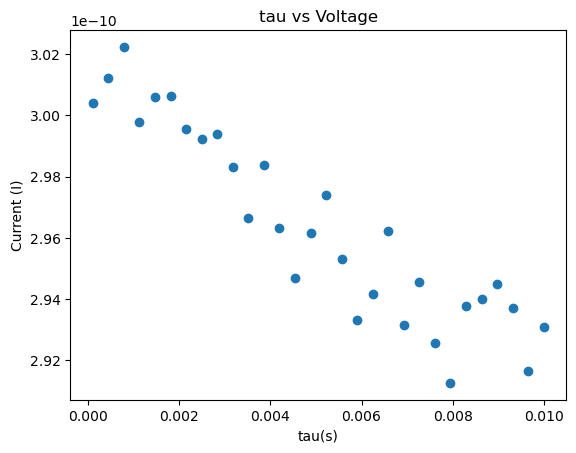

In [7]:
pulse_blaster.Stop()
T1_data = T1.to_pandas_dataframe()
T1_data.to_csv('T1.csv')
plt.plot(T1_data["tau"], T1_data["voltage"], 'o')
plt.xlabel('tau(s)')
plt.ylabel('Current (I)')
plt.title('tau vs Voltage')
plt.show()

To extract the $T_1$ time the decay must be fit. Below we define the fit model as a decaying exponential of the form $ae^{-\frac{\tau}{T_1}} + c$. Here, $a$ defines the magnitude of the spin signal at $\tau = 0$. i.e. the spin is fully polarised in the $|0\rangle$ state and $c$ is the offset photoluminescence. We define the fit model as a python function, with first argument $\tau$ (labeled as 'x' in the code) and the next three arguments are $a, T_1, c$. Our aim is to find the $\{a, T_1, c\}$ which produces a curve which most closely matches the experimental data. As this is non-linear fit, we must also provide the initial guess for the fit parameters $\{a, T_1, c\}$. This is an array of the $[{a}, {T_1}, {c}]$. From the data you have measured, choose the appropriate start points and fit the function. Extract the T1 value along with the associated error in the measurement.

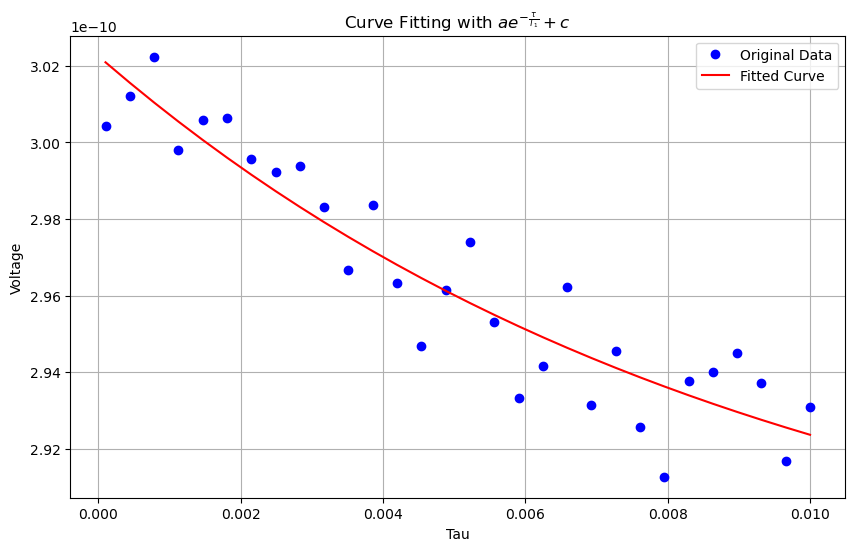

array([1.50181558e-11, 9.30532410e-03, 2.87235002e-10])

In [8]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the fitting function
def decay_func(tau, a, T_1, c):
    return a * np.exp(-tau / T_1) + c

# Extract tau and voltage values
tau = T1_data["tau"]
voltage = T1_data["voltage"]

# Perform the curve fitting
initial_guess = [1, 1, 1]  # Initial guess for the parameters [a, T_1, c]
params, covariance = curve_fit(decay_func, tau, voltage, p0=initial_guess)

# Extract the fitted parameters
a_fit, T_1_fit, c_fit = params

# Generate fitted data using the fitted parameters
voltage_fit = decay_func(tau, *params)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(tau, voltage, 'bo', label='Original Data')
plt.plot(tau, voltage_fit, 'r-', label='Fitted Curve')
plt.xlabel('Tau')
plt.ylabel('Voltage')
plt.legend()
plt.title('Curve Fitting with $ae^{-\\frac{\\tau}{T_1}} + c$')
plt.grid(True)
plt.show()

# Display the fitted parameters
params


In [9]:
print(covariance)

[[ 2.01454234e-23  2.18239251e-14 -2.18577312e-23]
 [ 2.18239251e-14  2.52005999e-05 -2.43607738e-14]
 [-2.18577312e-23 -2.43607738e-14  2.40598916e-23]]
